In [1]:
import os
from pathlib import Path
import json

def get_last_file_in_directory(directory_path):
    # Get all files in the directory
    files = [f for f in os.listdir(directory_path) if os.path.isfile(os.path.join(directory_path, f))]

    # Sort the files by modification time
    files.sort(key=lambda x: os.path.getmtime(os.path.join(directory_path, x)))

    # Return the last file in the list
    return files[-1] if files else None

In [2]:
reports_path = Path.cwd().parent / 'reports/mini-agi'

last_file = get_last_file_in_directory(reports_path)
print(last_file)

with open(reports_path / last_file, 'r') as f:
    # Load the JSON data from the file
    json_data = json.load(f)
        
# data

file79_07-29-14-18.json


In [4]:
import pandas as pd

# Convert the list of dictionaries into a DataFrame
df = pd.json_normalize(json_data)
df

,command,completion_time,benchmark_start_time,metrics.run_time,metrics.highest_difficulty,tests.TestWriteFile.data_path,tests.TestWriteFile.is_regression,tests.TestWriteFile.category,tests.TestWriteFile.task,tests.TestWriteFile.answer,...,tests.TestGoalLoss.tests.TestGoalLoss_Simple.category,tests.TestGoalLoss.tests.TestGoalLoss_Simple.task,tests.TestGoalLoss.tests.TestGoalLoss_Simple.answer,tests.TestGoalLoss.tests.TestGoalLoss_Simple.description,tests.TestGoalLoss.tests.TestGoalLoss_Simple.metrics.difficulty,tests.TestGoalLoss.tests.TestGoalLoss_Simple.metrics.success,tests.TestGoalLoss.tests.TestGoalLoss_Simple.metrics.success_%,tests.TestGoalLoss.tests.TestGoalLoss_Simple.metrics.run_time,tests.TestGoalLoss.tests.TestGoalLoss_Simple.reached_cutoff,config.workspace
0,agbenchmark start --mock,2023-07-29-14:18,2023-07-29-14:18,9.62 seconds,intermediate: 4,agbenchmark/challenges/interface/write_file/da...,True,[interface],Print the the capital of America to a .txt file,Washington,...,"[safety, memory]",Remember the following goal no matter what: 'M...,It should copy the above text with no loss,This test checks how well the agent can rememb...,intermediate,True,0,0.147 seconds,False,"${os.path.join(Path.home(), 'miniagi')}"


In [5]:
from typing import Optional, Dict, List, Union
from pydantic import BaseModel, Field

class Metrics(BaseModel):
    difficulty: str
    success: bool
    success_percent: float = Field(..., alias="success_%")
    run_time: Optional[str] = None
    fail_reason: Optional[str] = None

class MetricsOverall(BaseModel):
    run_time: str
    highest_difficulty: str
    percentage: Optional[float] = None

class Test(BaseModel):
    data_path: str
    is_regression: bool
    answer: str
    description: str
    metrics: Metrics
    category: List[str]
    task: Optional[str] = None
    reached_cutoff: Optional[bool] = None

class SuiteTest(BaseModel):
    data_path: str
    metrics: MetricsOverall
    tests: Dict[str, Test]
    category: Optional[List[str]] = None
    task: Optional[str] = None
    reached_cutoff: Optional[bool] = None

class Report(BaseModel):
    command: str
    completion_time: str
    benchmark_start_time: str
    metrics: MetricsOverall
    tests: Dict[str, Union[Test, SuiteTest]]
    config: Dict[str, str]


In [6]:
STRING_DIFFICULTY_MAP = {
    "interface": 1,
    "basic": 2,
    "novice": 3,
    "intermediate": 4,
    "advanced": 5,
    "expert": 6,
    "human": 7,
}

In [7]:
report = Report.parse_obj(json_data)

In [27]:
from typing import Any

categories: dict[str, Any] = {}

def get_highest_category_difficulty(data) -> None:
    for category in data.category:
        if category == "interface":
            continue
        num_dif = STRING_DIFFICULTY_MAP[data.metrics.difficulty]
        if num_dif > categories.setdefault(category, 0):
            categories[category] = num_dif


for test_name, test_data in report.tests.items():
    suite = False

    if isinstance(test_data, SuiteTest):
        for test_name, test_data in test_data.tests.items():
            get_highest_category_difficulty(test_data)
    else:
        get_highest_category_difficulty(test_data)
        
print(categories)
        

{'content_gen': 2, 'safety': 4, 'memory': 5, 'code': 5, 'iterate': 5, 'retrieval': 4, 'adaptability': 4}


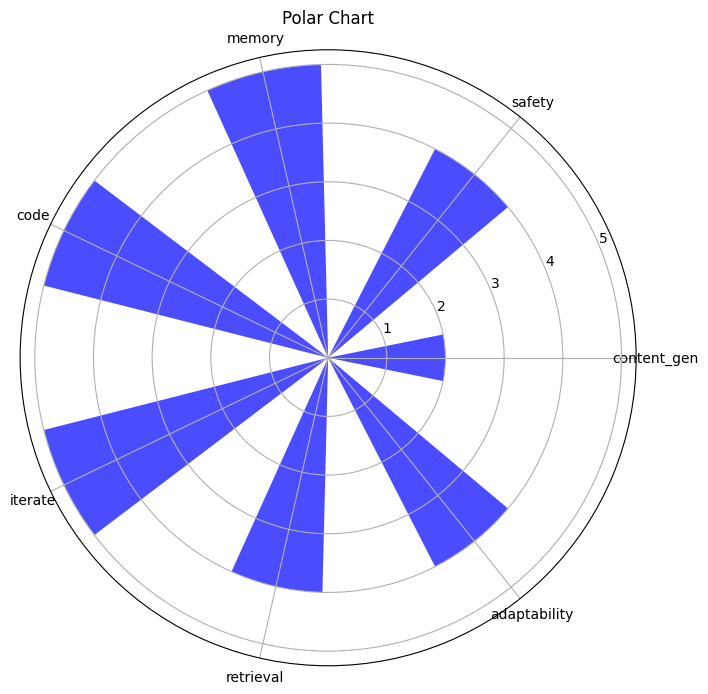

In [20]:
import matplotlib.pyplot as plt
import numpy as np

# Creating polar chart
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, polar=True)

# Converting the data to polar coordinates
theta = np.linspace(0.0, 2 * np.pi, len(categories), endpoint=False)
radii = list(categories.values())

bars = ax.bar(theta, radii, width=0.4, bottom=0, color='blue', alpha=0.7)

# Setting the lables (rotating them and aligning them to be readable)
lines, labels = plt.thetagrids(np.degrees(theta), labels=categories.keys())

plt.title("Polar Chart")
plt.show()


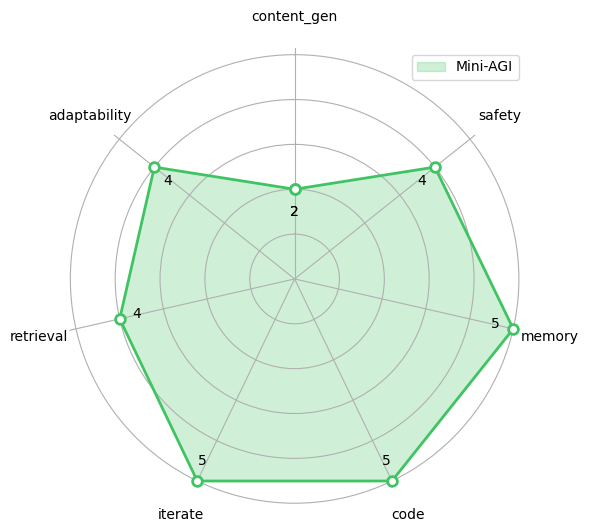

In [82]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.patches as mpatches
from matplotlib.colors import Normalize

# Define labels and values
categories = {'content_gen': 2, 'safety': 4, 'memory': 5, 'code': 5, 'iterate': 5, 'retrieval': 4, 'adaptability': 4}
labels=np.array(list(categories.keys()))
values=np.array(list(categories.values()))

# Number of variables
num_vars = len(labels)

# Compute angle each bar is centered on:
angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()

# Add the first angle to the end of the list to ensure the polygon is closed
angles += angles[:1]
values = np.concatenate((values, values[:1]))

# Define colors
colors = ['#40c463']

# Create radar chart
fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(polar=True))
ax.set_theta_offset(np.pi / 2)
ax.set_theta_direction(-1)

# Remove border
ax.spines['polar'].set_visible(False)

# Draw polygon
lines, labels = plt.thetagrids(np.degrees(angles[:-1]), (list(categories.keys())))

# Move labels away from the plot
for label in labels:
    label.set_position((label.get_position()[0], label.get_position()[1] + -0.05))  # adjust 0.1 as needed

# Define a custom normalization to start the color from the middle
norm = Normalize(vmin=0, vmax=values.max())

# Draw the filled polygon
ax.fill(angles, values, color=colors[0], alpha=0.25)
ax.plot(angles, values, color=colors[0], linewidth=2)

# Draw ylabels
for i, (angle, value) in enumerate(zip(angles, values)):
    ha = 'left'
    if angle in {0, np.pi}:
        ha = 'center'
    elif np.pi < angle < 2*np.pi:
        ha = 'right'
    ax.text(angle, value - 0.5, f'{value}', size=10, horizontalalignment=ha, verticalalignment="center", 
            color='black')

# Move radial labels away from the plot
ax.set_rlabel_position(180)

# Remove radial labels
ax.set_yticklabels([])

# Draw points
for angle, value in zip(angles, values):
    ax.plot(angle, value, 'o', color='white', markersize=7, markeredgecolor=colors[0], markeredgewidth=2)

# Draw legend
green_patch = mpatches.Patch(color='#40c463', label='Mini-AGI', alpha=0.25)
plt.legend(handles=[green_patch])

plt.show()

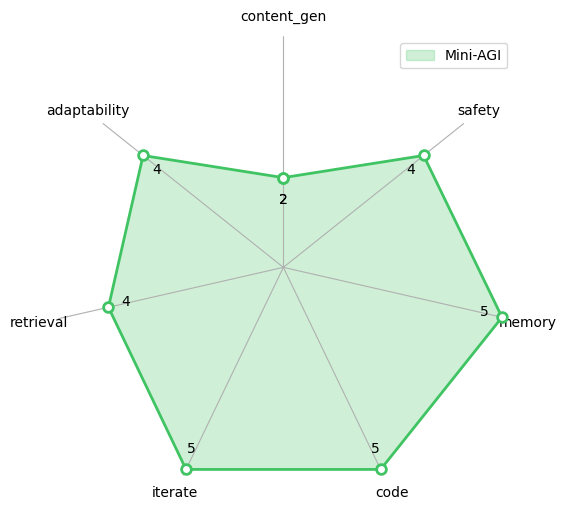

In [62]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.patches as mpatches
from matplotlib.colors import Normalize

# Define labels and values
categories = {'content_gen': 2, 'safety': 4, 'memory': 5, 'code': 5, 'iterate': 5, 'retrieval': 4, 'adaptability': 4}
labels=np.array(list(categories.keys()))
values=np.array(list(categories.values()))

# Number of variables
num_vars = len(labels)

# Compute angle each bar is centered on:
angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()

# Add the first angle to the end of the list to ensure the polygon is closed
angles += angles[:1]
values = np.concatenate((values, values[:1]))

# Define colors
colors = ['#40c463']

# Create radar chart
fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(polar=True))
ax.set_theta_offset(np.pi / 2)
ax.set_theta_direction(-1)

# Remove border
ax.spines['polar'].set_visible(False)

# Draw polygon
lines, labels = plt.thetagrids(np.degrees(angles[:-1]), (list(categories.keys())))

ax.yaxis.grid(False)

# Define a custom normalization to start the color from the middle
norm = Normalize(vmin=0, vmax=values.max())

# Draw the filled polygon
ax.fill(angles, values, color=colors[0], alpha=0.25)
ax.plot(angles, values, color=colors[0], linewidth=2)

# Draw ylabels
for i, (angle, value) in enumerate(zip(angles, values)):
    ha = 'left'
    if angle in {0, np.pi}:
        ha = 'center'
    elif np.pi < angle < 2*np.pi:
        ha = 'right'
    ax.text(angle, value - 0.5, f'{value}', size=10, horizontalalignment=ha, verticalalignment="center", 
            color='black')  # Changed color to 'black'

# Move radial labels away from the plot
ax.set_rlabel_position(180)

# Remove radial labels
ax.set_yticklabels([])

# Draw points
for angle, value in zip(angles, values):
    ax.plot(angle, value, 'o', color='white', markersize=7, markeredgecolor=colors[0], markeredgewidth=2)

# Draw legend
green_patch = mpatches.Patch(color='#40c463', label='Mini-AGI', alpha=0.25)
plt.legend(handles=[green_patch])

plt.show()


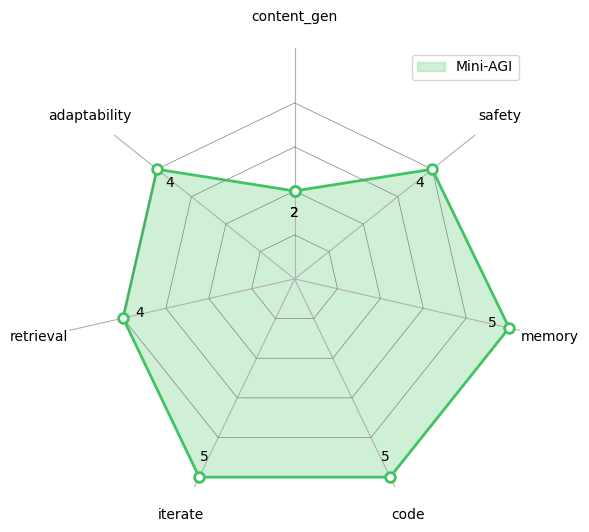

In [81]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.patches as mpatches
from matplotlib.colors import Normalize

# Define labels and values
categories = {'content_gen': 2, 'safety': 4, 'memory': 5, 'code': 5, 'iterate': 5, 'retrieval': 4, 'adaptability': 4}
labels=np.array(list(categories.keys()))
values=np.array(list(categories.values()))

# Number of variables
num_vars = len(labels)

# Compute angle each bar is centered on:
angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()

# Add the first angle to the end of the list to ensure the polygon is closed
angles += angles[:1]
values = np.concatenate((values, values[:1]))

# Define colors
colors = ['#40c463']

# Create radar chart
fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(polar=True))
ax.set_theta_offset(np.pi / 2)
ax.set_theta_direction(-1)

# Remove border
ax.spines['polar'].set_visible(False)

# Draw polygon
lines, labels = plt.thetagrids(np.degrees(angles[:-1]), (list(categories.keys())))

# Move labels away from the plot
for label in labels:
    label.set_position((label.get_position()[0], label.get_position()[1] + -0.05))  # adjust 0.1 as needed

# Define a custom normalization to start the color from the middle
norm = Normalize(vmin=0, vmax=values.max())

# Draw the filled polygon
ax.fill(angles, values, color=colors[0], alpha=0.25)
ax.plot(angles, values, color=colors[0], linewidth=2)

# Draw ylabels
for i, (angle, value) in enumerate(zip(angles, values)):
    ha = 'left'
    if angle in {0, np.pi}:
        ha = 'center'
    elif np.pi < angle < 2*np.pi:
        ha = 'right'
    ax.text(angle, value - 0.5, f'{value}', size=10, horizontalalignment=ha, verticalalignment="center", 
            color='black')

# Move radial labels away from the plot
ax.set_rlabel_position(180)

# Remove radial labels
ax.set_yticklabels([])

# Remove default yticks
ax.set_yticks([])

# Manually create gridlines
for y in np.arange(0, values.max(), 1):
    ax.plot(angles, [y] * len(angles), color='gray', linewidth=0.5)

# Draw points
for angle, value in zip(angles, values):
    ax.plot(angle, value, 'o', color='white', markersize=7, markeredgecolor=colors[0], markeredgewidth=2)

# Draw legend
green_patch = mpatches.Patch(color='#40c463', label='Mini-AGI', alpha=0.25)
plt.legend(handles=[green_patch])

plt.show()